,DIGNIDAD_CODIGO,DIGNIDAD_NOMBRE
0,11.0,PRESIDENTA/E Y VICEPRESIDENTA/E
19776,12.0,ASAMBLEÍSTAS NACIONALES
42024,13.0,ASAMBLEÍSTAS PROVINCIALES
66152,14.0,C.P. YASUNÍ PREGUNTA
71096,15.0,C.P. CHOCÓ ANDINO PREGUNTA 1
71356,16.0,C.P. CHOCÓ ANDINO PREGUNTA 2
71616,17.0,C.P. CHOCÓ ANDINO PREGUNTA 3
71876,18.0,C.P. CHOCÓ ANDINO PREGUNTA 4


,OP_CODIGO,CANDIDATO_NOMBRE
0,18.0,FERNANDO VILLAVICENCIO
1,207.0,LUISA GONZALEZ
2,208.0,BOLIVAR ARMIJOS
3,226.0,XAVIER HERVAS
4,1516.0,DANIEL NOBOA AZIN
5,1517.0,YAKU PEREZ
6,1525.0,OTTO SONNENHOLZNER
7,1543.0,JAN TOPIC


,PROVINCIA_CODIGO,CANTON_CODIGO,PARROQUIA_CODIGO,OP_CODIGO,VOTOS,DIGITO,SEXO
0,1.0,260.0,285.0,18.0,1195.0,1,F
1,1.0,260.0,285.0,207.0,2070.0,2,F
2,1.0,260.0,285.0,208.0,22.0,2,F
3,1.0,260.0,285.0,226.0,37.0,3,F
4,1.0,260.0,285.0,1516.0,2798.0,2,F
5,1.0,260.0,285.0,1517.0,892.0,8,F
6,1.0,260.0,285.0,1525.0,407.0,4,F
7,1.0,260.0,285.0,1543.0,981.0,9,F
8,1.0,260.0,285.0,18.0,965.0,9,M
9,1.0,260.0,285.0,207.0,1769.0,1,M


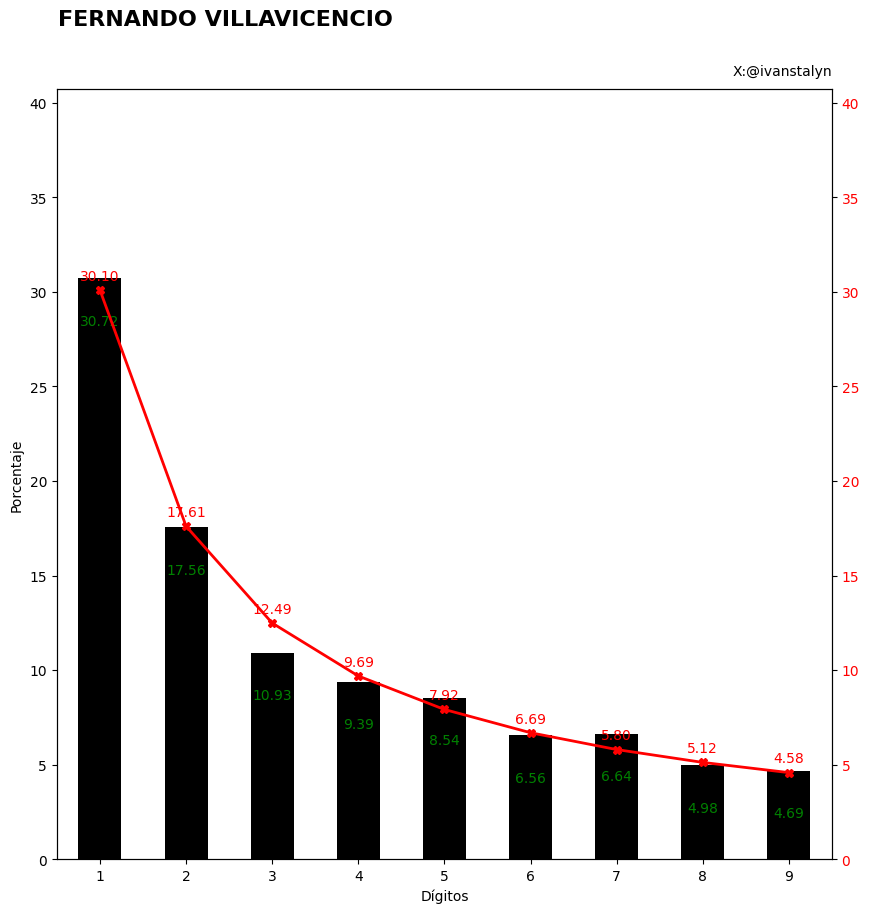

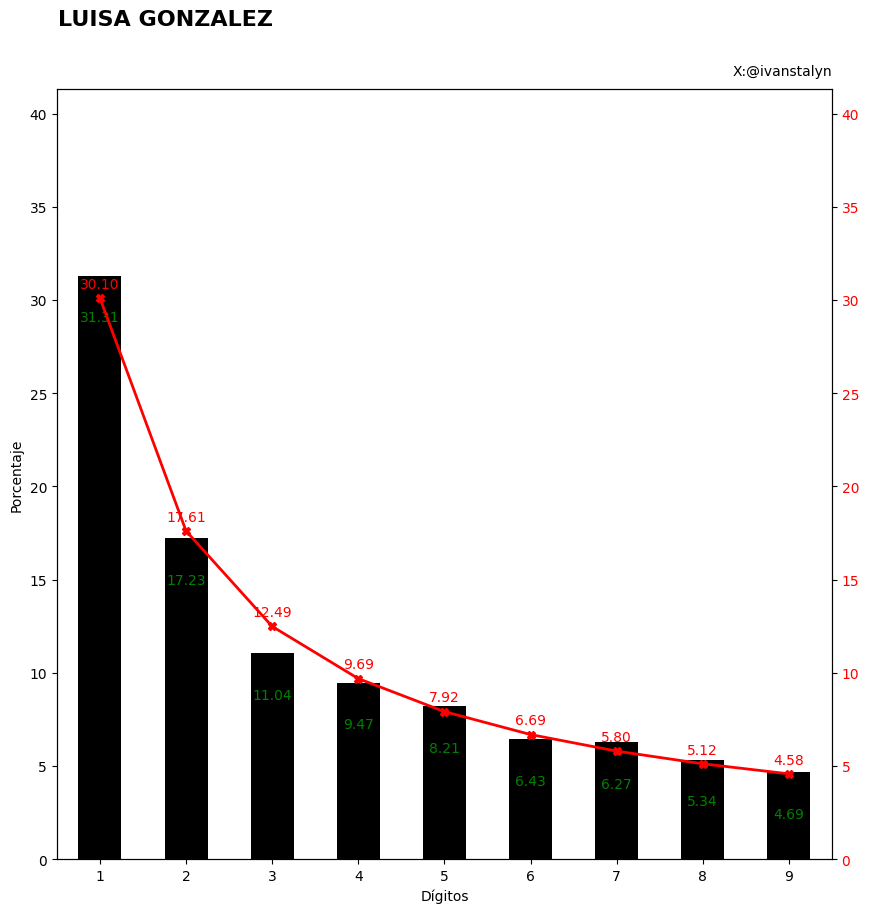

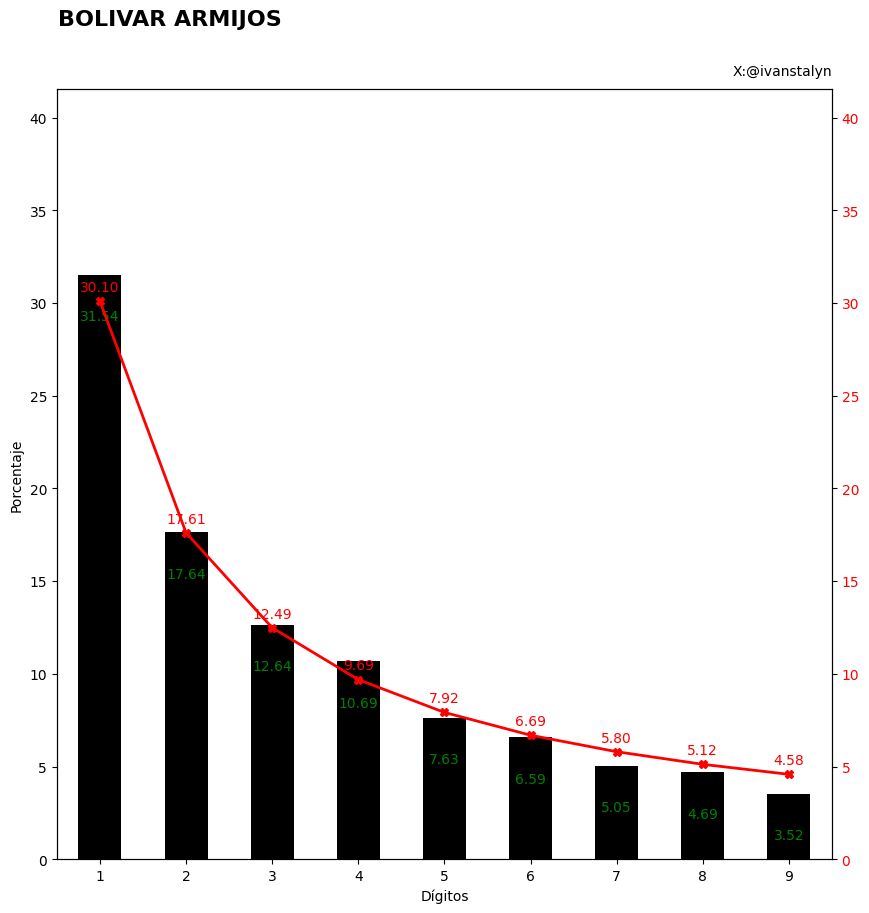

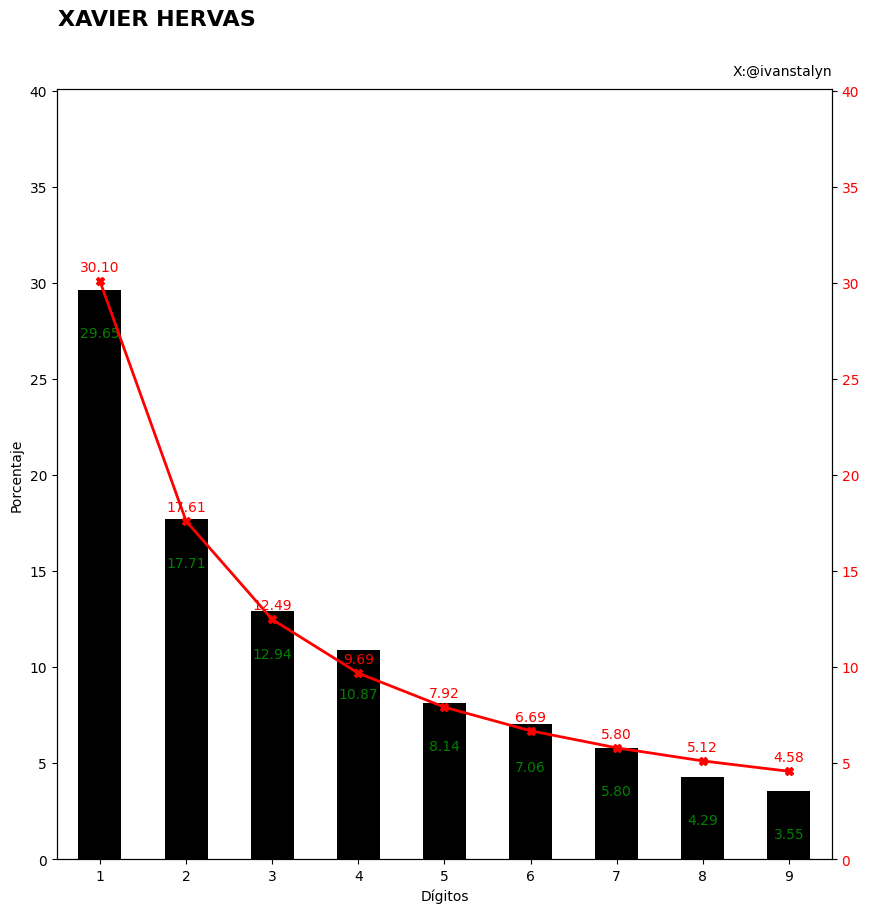

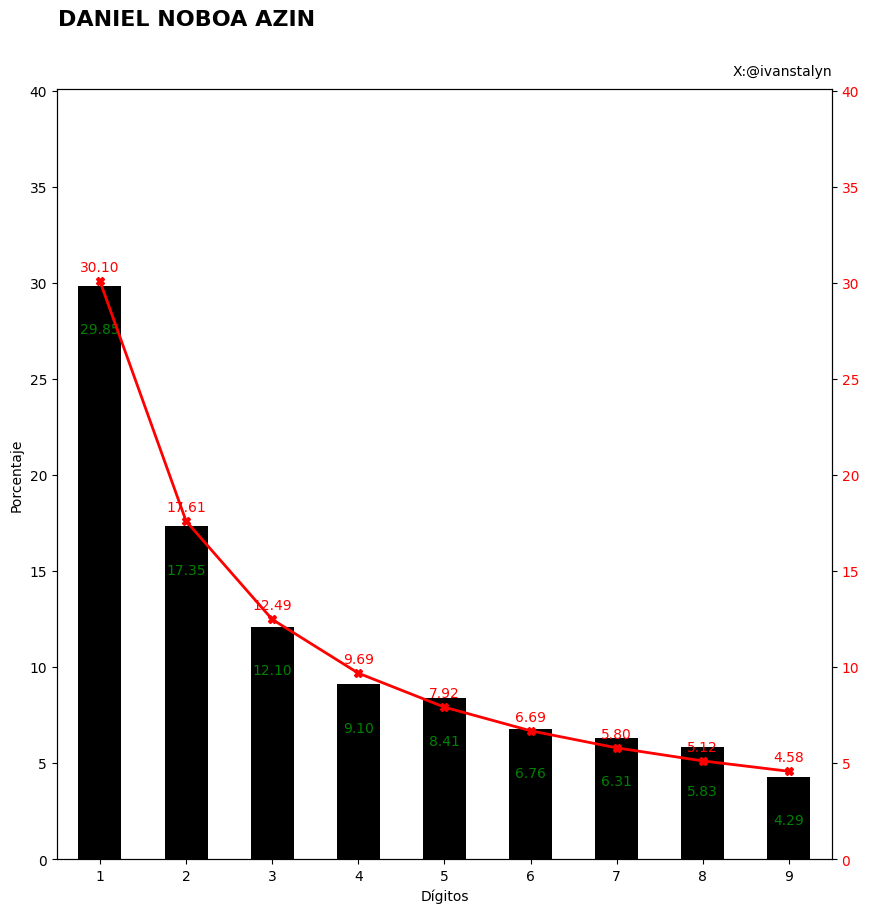

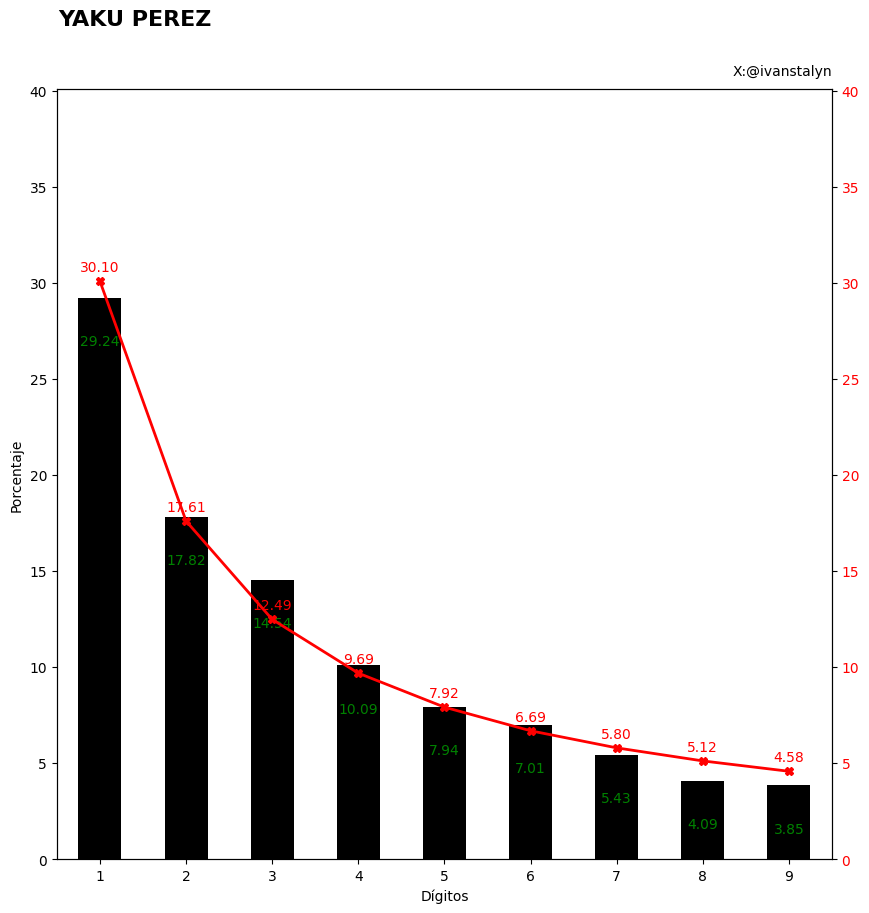

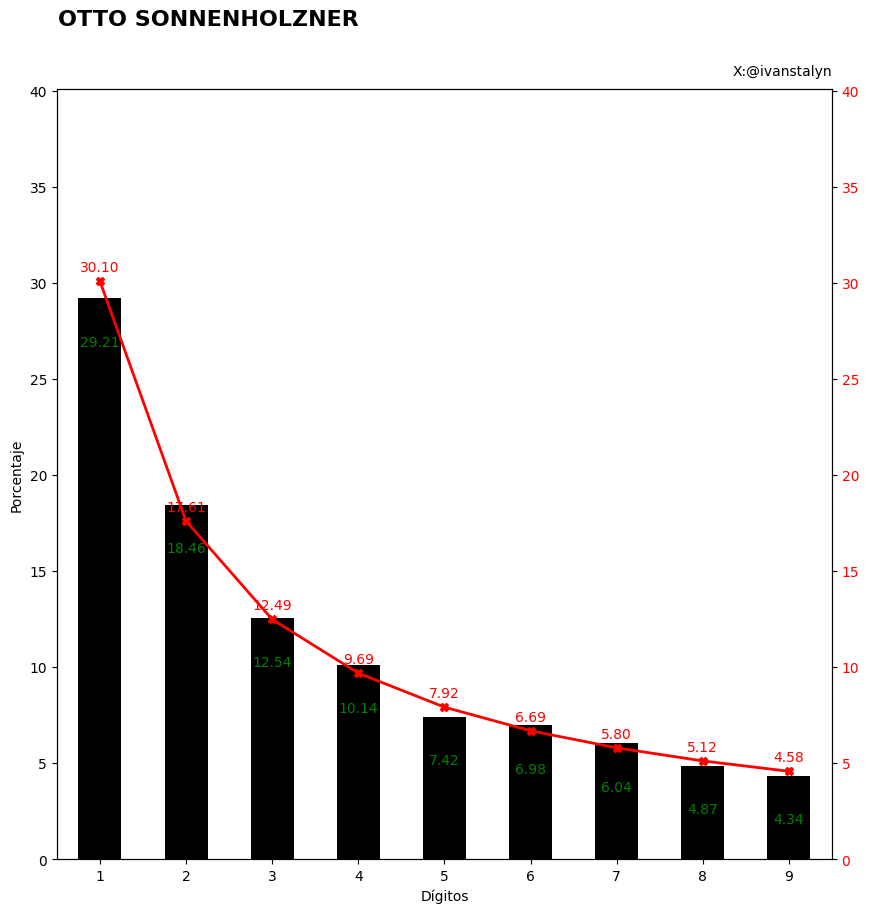

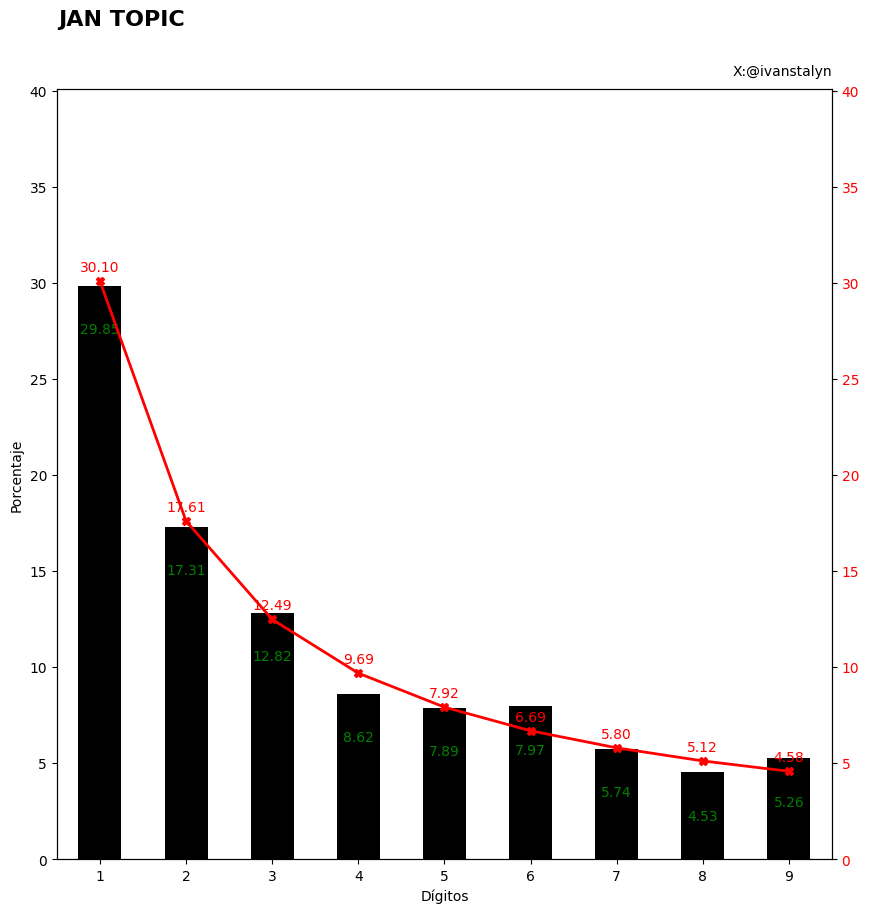

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import math


def add_value_labels(ax, typ, spacing=5):
    space = spacing
    va = 'bottom'

    if typ == 'bar':
        for i in ax.patches:
            y_value = i.get_height()
            x_value = i.get_x() + i.get_width() / 2

            y_pos = y_value - 3
            if y_pos < 0:
                y_pos = 0


            label = "{:.2f}".format(y_value)
            ax.annotate(label,(x_value, y_pos), xytext=(0, space), 
                    textcoords="offset points", ha='center', va=va, color= "green")     
    if typ == 'line':
        line = ax.lines[0]
        for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
            label = "{:.2f}".format(y_value)
            ax.annotate(label,(x_value, y_value), xytext=(0, space), 
                textcoords="offset points", ha='center', va=va, color="red")  

dfspss = pd.read_spss("otros/Primera-vuelta-2023.sav")

df_dignidades = dfspss.reindex(columns = ['DIGNIDAD_CODIGO', 'DIGNIDAD_NOMBRE']).drop_duplicates()
display(df_dignidades)

df_candidatos = dfspss[dfspss['DIGNIDAD_CODIGO'] == 11].reindex(columns = ['OP_CODIGO','CANDIDATO_NOMBRE']).drop_duplicates()
display(df_candidatos)

df_votos_presidente = dfspss[dfspss['DIGNIDAD_CODIGO'] == 11].reindex(columns = ['PROVINCIA_CODIGO', 'CANTON_CODIGO','PARROQUIA_CODIGO', 'JUNTA_SEXO', 'OP_CODIGO', 'VOTOS'])
df_votos_presidente['DIGITO'] = df_votos_presidente.apply(lambda row: int(str(row.VOTOS)[0]), axis=1 )
df_votos_presidente['SEXO'] = df_votos_presidente.apply(lambda row: 'M' if row.JUNTA_SEXO == 'MASCULINO' else 'F', axis=1 )
del df_votos_presidente['JUNTA_SEXO']

display(df_votos_presidente.head(16))

for index, candidato in df_candidatos.iterrows():
    df_votos_por_candidato = df_votos_presidente[df_votos_presidente['OP_CODIGO'] == candidato['OP_CODIGO']]
    
    df_benford_por_candidato = pd.DataFrame(columns=['DIGITO', 'CONTEO', 'PORCENTAJE','BENFORDSLAW'])
    for i in range(1, 10):
        conteo = df_votos_por_candidato['DIGITO'].value_counts().get(i, 0)
        benford = round(math.log10(1 + (1/i))*100, 2)
        df_benford_por_candidato.loc[i] = [i,conteo, 0, benford]
    
    df_benford_por_candidato['PORCENTAJE'] = round((df_benford_por_candidato['CONTEO'] / df_benford_por_candidato['CONTEO'].sum()) * 100, 2)
    
    maximo = df_benford_por_candidato['BENFORDSLAW'].max() + 10
    if df_benford_por_candidato['PORCENTAJE'].max() > df_benford_por_candidato['BENFORDSLAW'].max():
        maximo =  df_benford_por_candidato['PORCENTAJE'].max() + 10

    barras = df_benford_por_candidato['PORCENTAJE'].plot(kind="bar", figsize=(10, 10), color="#000000")
    barras.set_ylabel("Porcentaje")
    barras.set_xlabel("Dígitos")
    barras.set_ylim(0, maximo)

    for tick in barras.get_xticklabels():
        tick.set_rotation(0)
    
    linea = barras.twinx()
    linea.plot(barras.get_xticks(),df_benford_por_candidato['BENFORDSLAW'],color="#FF0000", linewidth=2, marker = "X")
    linea.grid(False)
    linea.set_ylim(0, maximo)
    
    add_value_labels(barras, typ='bar')
    add_value_labels(linea, typ='line')
    linea.tick_params(labelcolor="red", axis='y')
    

    plt.title(
        "X:@ivanstalyn",
        fontsize=10,
        pad=10,
        loc="right",
    )
    
    plt.suptitle(
        f"{candidato['CANDIDATO_NOMBRE']}",
        fontsize=16,
        fontweight="bold",
        x=0.126,
        y=0.96,
        ha="left",
    )

    plt.show()

